# MRSA workflow notebook

In this notebook we will run a Snakemake workflow and explore its results.

In [1]:
!snakemake

Building DAG of jobs...
Nothing to be done.
Complete log: /home/jovyan/workshop-reproducible-research/jupyter/.snakemake/log/2020-11-14T202948.480739.snakemake.log


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [3]:
def read_cov_tables(files):
    """Reads coverage tables for bedtools genomecov output"""
    import os
    df = pd.DataFrame()
    samples = []
    for i, f in enumerate(files):
        sample = os.path.basename(f).rstrip(".sorted.bam.cov.gz")
        # Use dtype=str for position to circumvent numpy future warning for elementwise comparison
        _df = pd.read_csv(f, sep="\t", header=None, index_col=0, usecols=[1,2], names=["position",sample], dtype={"position": str})
        if i==0:
            df = _df.copy()
        else:
            df = pd.merge(df, _df, left_index=True, right_index=True, how="outer")
    return df

def sliding_window(df, window=10000):
    """Sums aligned reads in a sliding window"""
    start, end = df.index[0], df.index[-1]
    prev = start
    windows = {}
    for x in list(range(start, end, window)):
        if prev == x:
            continue
        windows[x] = df.loc[prev:x].sum().to_dict()
        prev = x
    # Add final window
    if not end < list(range(start, end, window))[-1]:
        windows[end] = df.loc[prev:end].sum().to_dict()
    return pd.DataFrame(windows).T

In [4]:
%%bash
for f in $(ls intermediate/*.sorted.bam);
do
    bedtools genomecov -ibam $f -d | gzip -c > $f.cov.gz
done

In [5]:
import glob
files = glob.glob("intermediate/*.sorted.bam.cov.gz")
coverage_table = read_cov_tables(files)

In [6]:
coverage_table.head()

,SRR935090,SRR935091,SRR935092
position,,,
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
5,0,0,0


In [7]:
coverage_table.sample(5)

,SRR935090,SRR935091,SRR935092
position,,,
914460,0,0,1
1129652,1,0,0
2694183,2,0,4
1358958,0,0,1
525386,1,1,0


In [8]:
coverage_window = sliding_window(coverage_table, window=10000)

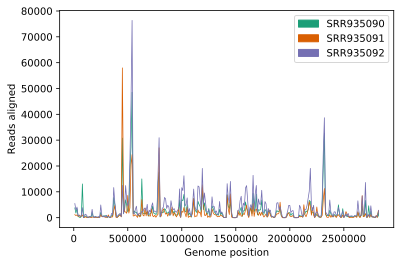

In [9]:
# Set the figure size
fig = plt.figure(figsize=(6,4))
# Set colors
colors = sns.color_palette("Dark2", n_colors=3)
# Set legend handles
handles = []
# Iterate samples and plot coverage
for i, sample in enumerate(coverage_window.columns):
    ax = sns.lineplot(x=coverage_window.index, y=coverage_window[sample],
        linewidth=.75, color=colors[i])
    # Update legend handles
    handles.append(mpatches.Patch(color=colors[i], label=sample))
# Set y and x labels
ax.set_ylabel("Reads aligned");
ax.set_xlabel("Genome position");
# Plot legend
plt.legend(handles=handles);

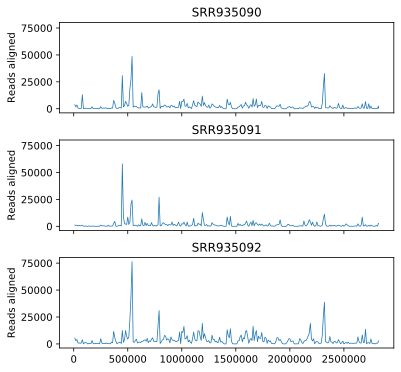

In [10]:
# Define the subplots
fig, axes = plt.subplots(ncols=1, nrows=3, sharey=True, sharex=True,
    figsize=(6,6))
# Iterate samples and plot in separate subplot
for i, sample in enumerate(coverage_window.columns):
    ax = sns.lineplot(x=coverage_window.index, y=coverage_window[sample],
        ax=axes[i], linewidth=.75)
    ax.set_title(sample)
    ax.set_ylabel("Reads aligned");
# Adjust space between subplots
plt.subplots_adjust(hspace=.3)

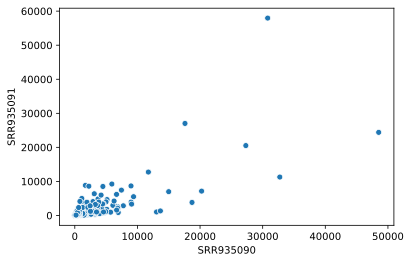

In [11]:
sns.scatterplot(x=coverage_window["SRR935090"],y=coverage_window["SRR935091"])

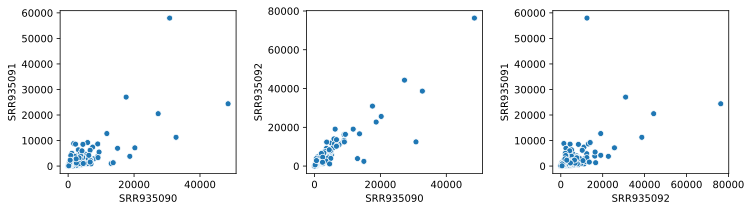

In [12]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12,3), sharex=False,
    sharey=False)
ax1 = sns.scatterplot(x=coverage_window["SRR935090"],
    y=coverage_window["SRR935091"], ax=axes[0])
ax2 = sns.scatterplot(x=coverage_window["SRR935090"],
    y=coverage_window["SRR935092"], ax=axes[1])
ax3 = sns.scatterplot(x=coverage_window["SRR935092"],
    y=coverage_window["SRR935091"], ax=axes[2])
plt.subplots_adjust(wspace=.4)